In [123]:
using Plots
theme(:dao);

In [109]:
using DelaySSAToolkit
using Catalyst
using BenchmarkTools


### SIR Model

In [36]:
rn = @reaction_network begin
    ρ, S+I --> E+I
    r, I --> R
end

Model ##ReactionSystem#270
States (4):
  S(t)
  I(t)
  E(t)
  R(t)
Parameters (2):
  ρ
  r

In [37]:
jumpsys = convert(JumpSystem, rn, combinatoric_ratelaws=false)

Model ##ReactionSystem#270
States (4):
  S(t)
  I(t)
  E(t)
  R(t)
Parameters (2):
  ρ
  r

In [38]:
u0 = [999,1,0,0] # S, I, E, R
tf = 400.0
tspan = (0.0,tf)
ps = [1e-4, 1e-2] # parameters for ρ, r
τ = 20.0
dprob = DiscreteProblem(jumpsys,u0,tspan,ps)

DiscreteProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 400.0)
u0: 4-element Vector{Int64}:
 999
   1
   0
   0

In [39]:
delay_trigger_affect! = function (integrator, rng)
    append!(integrator.de_chan[1], τ)
end
delay_trigger = Dict(1=>delay_trigger_affect!)
delay_interrupt = Dict()
delay_complete = Dict(1=>[2=>1, 3=>-1])
delayjumpset = DelayJumpSet(delay_trigger, delay_complete, delay_interrupt)

DelayJumpSet{var"#19#20", Vector{Pair{Int64, Int64}}, Function}(Dict(1 => var"#19#20"()), Dict(1 => [2 => 1, 3 => -1]), Dict{Int64, Function}(), [1], Int64[])

In [40]:
de_chan0 = [[]]
djprob = DelayJumpProblem(jumpsys, dprob, DelayRejection(), delayjumpset, de_chan0, save_positions=(true,true))


Number of constant rate jumps: 0
Number of variable rate jumps: 0
Have a mass action jump
Number of delay trigger reactions: 1
Number of delay interrupt reactions: 0


In [27]:
@btime sol = solve(djprob, SSAStepper());

  1.458 μs (30 allocations: 5.11 KiB)


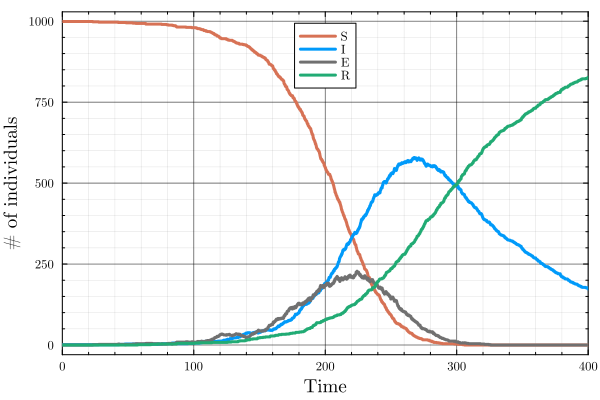

In [26]:
plot(
    sol;
    label=["S" "I" "E" "R"],
    linewidth=3,
    legend=:top,
    ylabel="# of individuals",
    xlabel="Time",
    fmt=:png,
)

### Delayed Telegraph Model

In [111]:
using Catalyst, DelaySSAToolkit
using Random, Distributions
rn = @reaction_network begin
    kon, Goff --> Gon
    koff, Gon --> Goff
    ρ, Gon --> Gon + N
end
jumpsys = convert(JumpSystem, rn; combinatoric_ratelaws=false)

Model ##ReactionSystem#298
States (3):
  Goff(t)
  Gon(t)
  N(t)
Parameters (3):
  kon
  koff
  ρ

In [85]:
u0 = [1, 0, 0] # Gon, Goff, N
ps = [0.0282,0.609,2.11] # parameters for ρ, r
tf = 200.0
tspan = (0.0, tf)
dprob = DiscreteProblem(u0, tspan,ps)

DiscreteProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 200.0)
u0: 3-element Vector{Int64}:
 1
 0
 0

In [ ]:
@btime rand(LogNormal(1, sqrt(2)))

  7.132 ns (0 allocations: 0 bytes)


0.805936860798485

#### Gamma Distribution

The Gamma distribution is defined by the following probability density function (PDF):

$ f(x; k, \theta) = \frac{x^{k-1} e^{-x/\theta}}{\theta^k \Gamma(k)} $

where:
- $ x $ is the random variable.
- $ k $ (or $ \alpha $) is the shape parameter.
- $ \theta $ (or $ \beta $) is the scale parameter.
- $ \Gamma(k) $ is the Gamma function.

##### Properties of the Gamma Distribution

- **Mean**: $ \mu = k \theta $
- **Variance**: $ \sigma^2 = k \theta^2 $

In [ ]:
delay_trigger_affect! = function (integrator, rng)
    τ = rand(LogNormal(1, sqrt(2))) + 120
    append!(integrator.de_chan[1], τ)
end
delay_trigger = Dict(3 => delay_trigger_affect!)
delay_complete = Dict(1 => [3 => -1])
delay_interrupt = Dict()
delayjumpset = DelayJumpSet(delay_trigger, delay_complete, delay_interrupt)

DelayJumpSet{var"#35#36", Vector{Pair{Int64, Int64}}, Function}(Dict(3 => var"#35#36"()), Dict(1 => [3 => -1]), Dict{Int64, Function}(), [3], Int64[])

In [87]:
de_chan0 = [[]]
djprob = DelayJumpProblem(jumpsys, dprob, DelayRejection(), delayjumpset, de_chan0, save_positions=(false,false))


Number of constant rate jumps: 0
Number of variable rate jumps: 0
Have a mass action jump
Number of delay trigger reactions: 1
Number of delay interrupt reactions: 0


In [88]:
ensprob = EnsembleProblem(djprob)
@time ens = solve(ensprob, SSAStepper(), EnsembleThreads(); trajectories=10^5)

  2.229110 seconds (17.92 M allocations: 1.227 GiB, 21.97% gc time, 13.98% compilation time)


EnsembleSolution Solution of length 100000 with uType:
Union{DelaySSAToolkit.DSSASolution{Vector{Vector{Int64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}}, ODESolution{Int64, 2, Vector{Vector{Int64}}, Nothing, Nothing, Vector{Float64}, Nothing, DiscreteProblem{Vector{Int64}, Tuple{Float64, Float64}, true, Vector{Float64}, DiscreteFunction{true, SciMLBase.FullSpecialize, SciMLBase.var"#234#235", Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}, SSAStepper, SciMLBase.ConstantInterpolation{Vector{Float64}, Vector{Vector{Int64}}}, SciMLBase.DEStats, Nothing, Nothing, Nothing}}

In [99]:
protein = [ensemble.u[2][3] for ensemble in ens];

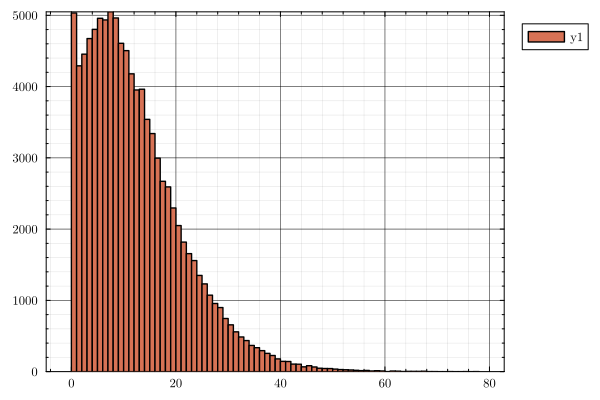

In [100]:
histogram(protein,bins=:scott)

### JAK-STAT Model

In [110]:
rn = @reaction_network begin
    k0, IFNγ --> 0
    k1, IFNγ + Ir --> IIr 
    k2, IIr --> IFNγ
    k6, STAT1n 
    ρ, Gon --> Gon + N
end

LoadError: LoadError: type Symbol has no field head
in expression starting at In[110]:1

### Michaelis Menten Reaction

In [ ]:
using Catalyst
using DifferentialEquations
using Plots

# Define the reaction network with updated syntax
@parameters k1 k2 k3 k4 k5
@variables t
@species S(t) E(t) ES(t) P(t) I(t) EI(t)

rn = @reaction_network begin
    (k1, k2), S + E ↔ ES
    k3, ES → E + P
    (k4, k5), I + E ↔ EI
end

# Initial concentrations
u0 = [S => 10.0, E => 1.0, ES => 0.0, P => 0.0, I => 1.0, EI => 0.0]

# Parameters: k1, k2, k3, k4, k5
p = [0.1, 0.1, 0.1, 0.1, 0.1]

# Time span
tspan = (0.0, 500.0)

# Solve the differential equations
prob = ODEProblem(rn, u0, tspan, p)

# Plot enzyme concentration E
plot(sol, idxs=[:E], xlabel="Time", ylabel="Concentration", label="Enzyme")

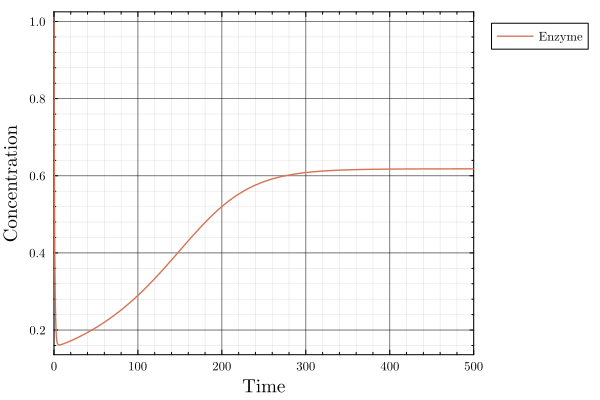

In [132]:
# Plot only enzyme concentration E
plot(sol, idxs=[:E], xlabel="Time", ylabel="Concentration", label="Enzyme")